**Deep learning project: image colorization**

The this project is using the image colorization network by moein-shariatnia as a basis. and extends it. https://github.com/moein-shariatnia/Deep-Learning/tree/main/Image%20Colorization%20Tutorial

In [ ]:
input_size = 64 #sets the a x a size that will be used to train models. If the size is has not been used before the scripts below will resize 
                  # the images to this size and safe it as a new data set
use_tiny_set = True # wether to use only the first 1000 images or the full 21k set
Tiny_set_size = 3000
train_pct = 0.80

batch_size = 16

updates_per_epoch = 2

# imports, Setting up, loading data and defining stuff


In [ ]:
#get dataset through fast ai
!pip install fastai --upgrade
from fastai.data.external import untar_data, URLs
coco_path = untar_data(URLs.COCO_SAMPLE)
path = str(coco_path) + "/train_sample"

import torch
import numpy as np
from numpy import random
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #use GPU if available
paths = glob.glob(path + "/*.jpg")


if(use_tiny_set):
  set_size = Tiny_set_size
else:
  set_size = 10000

split = (int)(set_size*train_pct)
np.random.seed(123)
paths_subset = np.random.choice(paths, set_size, replace=False) # choosing 1000 images randomly
rand_idxs = np.random.permutation(set_size)
train_idxs = rand_idxs[:split]
val_idxs = rand_idxs[split:] 
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]


from skimage.color import rgb2lab, lab2rgb
import matplotlib.pyplot as plt

import time 
import torch.nn.functional as F


In [ ]:
#useful functions
def labToRGB(L,ab):
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab]).permute(1, 2, 0).numpy()
    rgb = lab2rgb(Lab)
    return rgb

def batch_labToRGB(L,ab):
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).detach().cpu().numpy()
    rgb = lab2rgb(Lab)
    return rgb
    
def sample_batch(model,dataloader):
    L,real_color = next(iter(loader))   
    L,real_color = L.to(device),real_color.to(device)
    model.to(device)
    out = model.forward(L)
    sf = 3 #scaling factor 
    fig, ax = plt.subplots(batch_size,2, figsize=(2*sf,batch_size*sf)) 
  
    for guess,truth,i in zip(batch_labToRGB(L,out), batch_labToRGB(L,real_color) ,range(batch_size)):
      ax[i,0].imshow(guess)
      ax[i,0].axis("off")
      ax[i,1].imshow(truth)
      ax[i,1].axis("off")

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.4 GB  |     Proc size: 1.2 GB
GPU RAM Free: 16278MB | Used: 2MB | Util   0% | Total     16280MB


tensor([[[-0.5409, -0.7781, -0.4828,  ..., -0.0397, -0.0343, -0.0861],
         [-0.5908, -0.7011, -0.5085,  ..., -0.0750, -0.0620, -0.1059],
         [-0.6358, -0.6272, -0.5403,  ..., -0.0988, -0.0799, -0.1019],
         ...,
         [ 0.9829,  0.9820,  0.9351,  ..., -0.0412, -0.0333,  0.2021],
         [ 0.9775,  0.9775,  0.9157,  ..., -0.0436, -0.0238,  0.0980],
         [ 0.9761,  0.9853,  0.9088,  ...,  0.0071, -0.0040,  0.0860]]])
2400


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


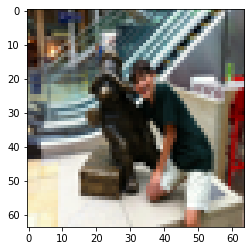

In [ ]:
class coloring_dataset(Dataset):
  def __init__ (self,paths):
    self.paths = paths
    self.transforms = transforms.Resize((input_size,input_size), Image.BICUBIC)

  def __getitem__(self, idx):
    img = Image.open(self.paths[idx]).convert("RGB")
    imT = self.transforms(img)
    imT = np.array(imT)
    imT = rgb2lab(imT).astype("float32")
    imT = transforms.ToTensor()(imT)
    Lightness = imT[[0], ...] / 50. - 1. # Between -1 and 1
    ab = imT[[1, 2], ...] / 110. # Between -1 and 1
    return Lightness,ab

  def __len__(self):
    return len(self.paths)

a = coloring_dataset(train_paths) 

#confirm transformations are working 
for index,(L,ab) in enumerate(a):
  print(L)
  plt.imshow(labToRGB(L,ab))
  break

print(len(a))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


<Figure size 432x288 with 0 Axes>

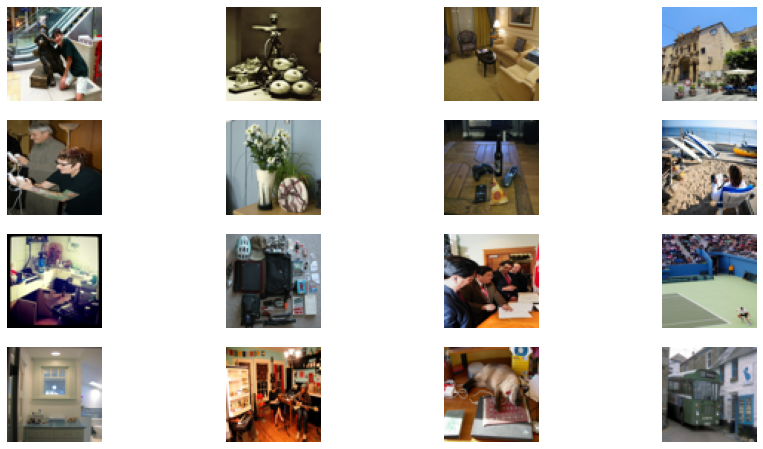

In [ ]:
#data loader
train_loader = DataLoader(a,batch_size=batch_size,num_workers=4,pin_memory=True) # only two data loaders because colab complains if more than 3
batch = next(iter(train_loader))

import math
plt.figure()
_cols = math.ceil(math.sqrt(len(batch[0])))
_rows =  math.ceil(len(batch[0])/_cols)
fig, axarr = plt.subplots(_rows,_cols, figsize=(15,8)) 
row = 2
col = 0

for l,ab,ax in zip(batch[0],batch[1],axarr.flatten()):
  ax.imshow(labToRGB(l,ab))
  ax.axis("off")

In [ ]:
def init_weights(net, init='norm', gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

# Training simple CNN 
CNN's seem like the obvious way to approach these tasks
general findings from experimenting



1.   Preprocessing the data set speeds computation up massively
2.   Convolutional filters with smaller kernels do better, or atleast encourage less "average" guesses
3.   The model produces very boring brown looking results, likely because brown is the average color
4. Even a relatively large model with many parameters is unlikely to make actual color guesses
5. model converges very quickly on the small data set improvements stop happening after 3-4 epochs

Therefore, it's time to introduce a more auto encoder style structure via ConvTranspose layers


23:52:59
model initialized with norm initialization
Gen RAM Free: 11.0 GB  |     Proc size: 3.8 GB
GPU RAM Free: 16278MB | Used: 2MB | Util   0% | Total     16280MB


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[    1,   75] loss: 0.2518436383207639 t 0:00:10.112662
[    1,  150] loss: 0.10807371576627095 t 0:00:09.165447
[    2,   75] loss: 0.11013763219118118 t 0:00:10.054555
[    2,  150] loss: 0.10969463547070821 t 0:00:09.130075
[    3,   75] loss: 0.10131162603696188 t 0:00:10.134925
[    3,  150] loss: 0.09665400356054306 t 0:00:09.004322


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


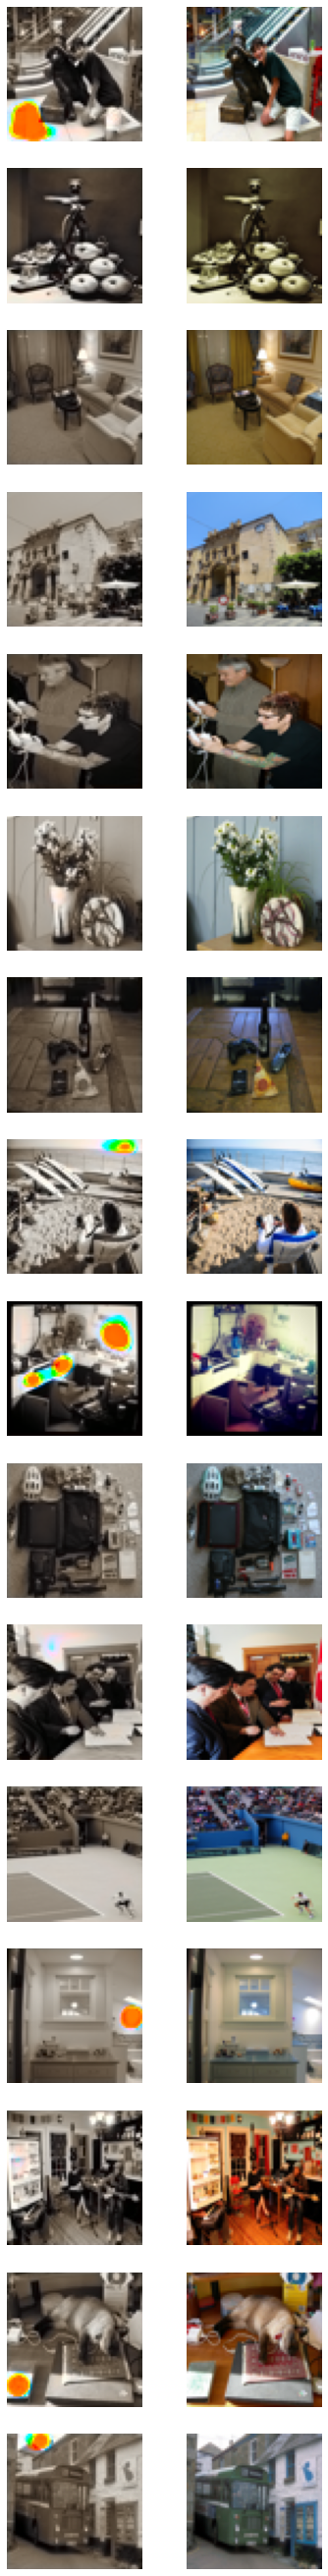

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.convolution = nn.Sequential( 
            nn.Conv2d(1, 256, 3,padding=1),
            nn.LeakyReLU(),

            nn.Conv2d(256, 64, 3,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),

            nn.Conv2d(64, 64, 3,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            
            nn.Conv2d(64, 64, 3,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),

            nn.Conv2d(64, 64, 3,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            
            nn.Conv2d(64, 128,  3,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 512,  3,padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            
            nn.Conv2d(512, 2, 3,padding=1),
            nn.Tanh()
            )

    def forward(self, x):
        x = self.convolution(x)
        return x

criterion = nn.L1Loss()

loader = train_loader
update_freq = (int)(len(loader)/updates_per_epoch)

from datetime import datetime
past = datetime.now()
print(past.strftime("%H:%M:%S"))
#move to GPU and set optimiser
import torch.optim as optim
net = Net().to(device)
net = init_weights(net)

optimizer = optim.Adam(net.parameters())
printm()
for epoch in range(3):
  mean_loss = 0.0
  for i, (L, real_color) in enumerate(loader, 0):
    # get lightness and data to regress towards
    L, real_color = L.to(device), real_color.to(device)
    #zero the gradients
    net.zero_grad()
    #get model guess

    fake_color = net(L)
    #evaluate performance
    loss = criterion(fake_color,real_color)
    #backwards pass
    loss.backward()
    optimizer.step()
    
    mean_loss += float(loss)
    if i % update_freq == update_freq-1:
        now = datetime.now()
        print(f'[{epoch + 1:5},{i + 1:5}] loss: {mean_loss / update_freq:5} t {now-past}')
        past = now
        mean_loss = 0.0

sample_batch(net,train_loader)

# Conditional Generator Network 

before moving onto more advanced image generating networks i'll first introduce a conditional adversarial network, since i believe that this will be able to massively improve the output 



23:57:54
Gen RAM Free: 11.0 GB  |     Proc size: 3.9 GB
GPU RAM Free: 16278MB | Used: 2MB | Util   0% | Total     16280MB


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[    1,   75] loss: 0.24051031788190205 discr_loss: 1.180432176589966 t 0:00:10.834952
[    1,  150] loss: 0.13178450951973597 discr_loss: 2.1904415973027547 t 0:00:09.930867
[    2,   75] loss: 0.11608891119559606 discr_loss: 1.0134815804163615 t 0:00:10.918150
[    2,  150] loss: 0.10355245749155681 discr_loss: 2.028037508328756 t 0:00:10.128266
[    3,   75] loss: 0.10271467834711075 discr_loss: 1.009890702565511 t 0:00:10.844702
[    3,  150] loss: 0.09399642199277877 discr_loss: 2.0183676131566366 t 0:00:10.206979
[    4,   75] loss: 0.1234060933192571 discr_loss: 1.0333220672607422 t 0:00:10.839038
[    4,  150] loss: 0.1322238434354464 discr_loss: 2.129842546780904 t 0:00:10.092281
[    5,   75] loss: 0.1148175659775734 discr_loss: 1.0836066754659017 t 0:00:10.821700
[    5,  150] loss: 0.10473917146523794 discr_loss: 2.0988106966018676 t 0:00:10.105759
[    6,   75] loss: 0.1192355748017629 discr_loss: 1.014612963994344 t 0:00:11.150247
[    6,  150] loss: 0.10963845441738765 d

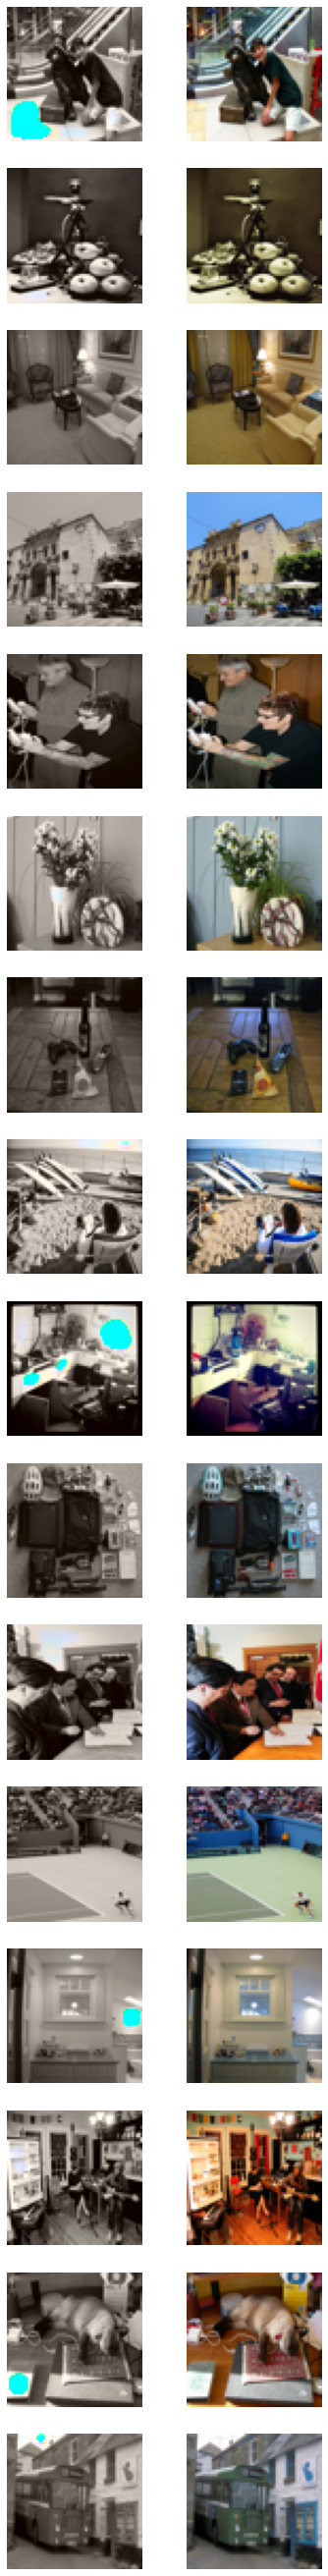

In [ ]:
class Simple_Discriminator(nn.Module):
    def __init__(self, ndf):
      super().__init__()
      self.main = nn.Sequential(

          nn.Conv2d(2, ndf, 4, 2, 1, bias=False),
          nn.LeakyReLU(0.2, True),

          nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ndf * 2),
          nn.LeakyReLU(0.2, True),

          nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ndf * 4),
          nn.LeakyReLU(0.2, True),

          nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
          nn.BatchNorm2d(ndf * 8),
          nn.LeakyReLU(0.2, True),

          nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
          nn.Sigmoid()
      )

    def forward(self, input):
        return self.main(input)

#update parameters
update_freq = (int)(len(loader)/updates_per_epoch)
from datetime import datetime
past = datetime.now()
print(past.strftime("%H:%M:%S"))


#instance the models and their criterias and move to GPU
#TODO generate weights, check if label generation can be moved outside of loop, also make sure that things are being detached when needed, try comparison that also includes lightness
import torch.optim as optim
d = Simple_Discriminator(64).to(device)
#d = init_weights(d)
d_criterion = nn.BCEWithLogitsLoss()
d_optimizer = optim.Adam(d.parameters())

g = Net().to(device)
#g = init_weights(g)
g_criterion = nn.L1Loss()
g_optimizer = optim.Adam(g.parameters())


loader = train_loader

wd = 0.5 #decides how to weight the l1 and discriminator loss when training the generator 0.8 mean 80 pct from disciminator

printm()
for epoch in range(20):
  mean_loss, mean_loss2 = 0.0,0.0
  for i, (L, real_color) in enumerate(loader, 0):
    # get lightness and data 
    L, real_color = L.to(device), real_color.to(device)

  #first the discriminator's training phase
    #Create the label tensors that are used to train the discriminator 
    fake_label = torch.full((L.size(0),1,1,1), 0.0, dtype=torch.float, device=device, requires_grad = False)
    real_label = torch.full((L.size(0),1,1,1), 1.0, dtype=torch.float, device=device, requires_grad = False)


    #zero gradients
    d_optimizer.zero_grad()

    #training with instances from dataset 
    real_guess = d(real_color)
    real_loss = d_criterion(real_guess,real_label)

    #training with instances from generator 
    fake_color = g(L)
    fake_guess = d(fake_color)
    fake_loss = d_criterion(fake_guess,fake_label)

    #do backwards pass and update weights
    sums_loss = fake_loss + real_loss
    sums_loss.backward()
    d_optimizer.step()

    L, real_color = L.to(device), real_color.to(device)

  #now for g training pass
    #zero the gradients
    g_optimizer.zero_grad()
    #get model guess
    color_guess = g(L)
    guess_discr = d(color_guess)
    #evaluate performance
    loss_color = g_criterion(color_guess,real_color)
    loss_discr = d_criterion(guess_discr,fake_label)
    loss_gener = ((1.0 - wd)*loss_color + wd*loss_discr)*0.5
    #backwards pass
    loss_gener.backward()
    g_optimizer.step()
    
    mean_loss += float(loss_color)
    mean_loss2 += float(sums_loss)
    if i % update_freq == update_freq-1:
        now = datetime.now()
        print(f'[{epoch + 1:5},{i + 1:5}] loss: {(mean_loss / update_freq):5} discr_loss: {(mean_loss2 / update_freq):5} t {now-past}')
        past = now
        mean_loss = 0.0

sample_batch(g,train_loader)
